## Project: Bank Analysis - Tweets 
Using Twint to scrape tweets 

Use beautiful soup to clean tweets with WordPunctTokenizer


# Quick Twint code
Github - https://github.com/twintproject/twint

All functions - https://github.com/twintproject/twint/wiki/Configuration
### setup 
c.twint.Config() 

#### set username
c.Username = "realDonaldTrump"

#### set phrase search
c.Search = "great"

#### customise output
c.Custom["tweet"] = ["id"]           --- assign column names

c.Custom["user"] = ["bio"]

c.Limit = 1                          ---- limit to batches (unknown size)

c.Since = "2019–04–29"

c.Until = "2020–04–29"

#### Pandas 
c.Pandas = True

    --------once run save to dataframe
    
    ---- Tweets 
    df = twint.storage.panda.Tweets_df
    
    ---- followers 
    df = twint.storage.panda.Follow_df
    
    df = Followers_df['followers'][username]

#### Write output 
c.Store_csv = True

c.Output = "test.csv"

### Execute determines how its run- using setup above
twint.run.Search(c)    --- will run search for all tweets with the above

twint.run.Profile(c)   ---- will run against profile - return only this profiles tweets

twint.run.Followers(c) ---- get follower info 


config.Since = "2019–04–29"\
config.Until = "2020–04–29"\
config.Store_json = True


In [1]:
import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()            #for compatibility issues 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns

### Configure and run Twint (twitter scrapper)

In [171]:
twintconfig = twint.Config()


bankString = "@StandardBankZA OR \"Standard Bank\""

twintconfig.Search = bankString
twintconfig.Pandas_clean = True

## timeframe
twintconfig.Since = "2021-05-27"
twintconfig.Until = "2021-05-30"

twintconfig.Pandas = True
twintconfig.Pandas_clean= True

twintconfig.lang = "en"


In [85]:
%%time
#run Search 
twint.run.Search(twintconfig)

1398788049526530054 2021-05-30 01:47:13 +0200 <StandardBankZA> @Makhuele Good day  Kindly note you will need to visit a Standard Bank branch in order to open the account.
1398784480148705288 2021-05-30 01:33:02 +0200 <moses57347335> @StandardBankZA @SerengetiEST We as Ugandans have not benefited in your out money plz stop and don’t finance the pipeline 🙏
1398783943529439239 2021-05-30 01:30:54 +0200 <moses57347335> @StandardBankZA @SerengetiEST Don’t finance uganda pipeline please Uganda is bleeding
1398768292601401344 2021-05-30 00:28:43 +0200 <CoinDCX> @shivam_s15 Hi Shivam, You can deposit via our website  https://t.co/vzS4fYUcKk and use Standard Bank Deposit option. There are no charges but it can take upto 72 hours
1398767036629766146 2021-05-30 00:23:44 +0200 <RasheedAgbaje2> @StandardBankZA Yes beautiful i love it...
1398766545493442560 2021-05-30 00:21:46 +0200 <davis_biggy> @StandardBankZA @SerengetiEST  https://t.co/3vEZ5xLkPC
1398765862304337929 2021-05-30 00:19:04 +0200 <da

1398638316560519170 2021-05-29 15:52:14 +0200 <Bizaro_Bilasky> @StandardBankZA The is No Option for Dstv payment
1398636431216713739 2021-05-29 15:44:45 +0200 <CIPEAfrica> New projects @AfCFTA secretariat is working on: -a digital platform to help SMEs access new markets -a trade finance policy with @StandardBankZA to help SMEs trade -a pan-African payments &amp; settlement platform with @afreximbank  -digitise customs functions  https://t.co/LagmxPYvo7
1398634235653726208 2021-05-29 15:36:01 +0200 <Bizaro_Bilasky> @StandardBankZA I want to pay my Dstv acc via this App
1398633767946784771 2021-05-29 15:34:10 +0200 <lilimobeth> @lukben01 @DorcasDee18 @StandardBankZA Right!
1398633699932049408 2021-05-29 15:33:54 +0200 <batsman87> @StandardBankZA Elite
1398630451770691586 2021-05-29 15:20:59 +0200 <JjukoPrince> @StandardBankZA Uganda is bleeding stop funding dictator museveni he is not the president of Uganda we voted kyangulanyi ssentamu Robert not dictator museveni  https://t.co/Bl6TJp

1398575057660678147 2021-05-29 11:40:52 +0200 <_LungaNgcobo> @balungile_s @MoStrong_ @thulasindi Phased out? Standard bank still offers hey
1398574265637683201 2021-05-29 11:37:43 +0200 <phatQuen> @StandardBankZA #BeacouseUCount  https://t.co/qHrKbQRQzw
1398573956806987779 2021-05-29 11:36:30 +0200 <Glamology_ZA> @busiswastemele Hi sisi, I have FNB, Standard Bank and Nedbank. I can provide details depending on your bank. If you use none of these. I will provide my FNB acc details
1398573882295173129 2021-05-29 11:36:12 +0200 <Dr_Uncle_> How’s Standard Bank’s online banking experience?
1398573729903517700 2021-05-29 11:35:36 +0200 <Man0fColour> @StandardBankZA @StandardBankZA #BecauseUCount @StandardBankZA  https://t.co/FJN14r5oDW
1398571959881961474 2021-05-29 11:28:34 +0200 <soso_gcelu> @StandardBankZA #BecauseUCount  https://t.co/GGCdqFDkDs
1398570558711808002 2021-05-29 11:23:00 +0200 <MoushZN> @StandardBankZA #BecauseUCount  https://t.co/SsFZQhUKXB
1398569947283005441 2021-05-29 11

1398462670936985606 2021-05-29 04:14:17 +0200 <ballard_lord> @StandardBankZA Stop financing the East African oil pipeline.  #UgandaIsBleeding #NoDemocracyInUganda
1398462582042812417 2021-05-29 04:13:56 +0200 <Dalanamz> . @StandardBankZA  financing a new oil pipeline in the midst of a #climateemergency is grossly irresponsible. Don't finance the East African Crude Oil Pipeline. Promote investment in clean energy for East Africa instead! #StopEACOP #UgandaIsBleeding
1398462154450276353 2021-05-29 04:12:14 +0200 <Dalanamz> @StandardBankZA  financing a new oil pipeline in the midst of a #climateemergency is grossly irresponsible. Don't finance the East African Crude Oil Pipeline. Promote investment in clean energy for East Africa instead! #StopEACOP #visituganda #UgandaIsBleeding
1398457640133464070 2021-05-29 03:54:18 +0200 <MuwongeMike6> @StandardBankZA #UgandaIsBleedingSilently #VisitUganda  https://t.co/JDwSUCm4GK
1398456904343564294 2021-05-29 03:51:22 +0200 <KikaziR> @StandardBankZA

## Pandas - analyse the data

In [86]:
#set pandas
tweets_df = twint.storage.panda.Tweets_df

In [87]:
tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [88]:
len(tweets_df)

193

In [89]:
#Export to csv
tweets_df.to_csv("pre_cleaning.csv")

In [90]:
sub_tweets = tweets_df[["date", "username", "tweet", "hashtags", "nlikes","search"]]

In [91]:
sub_tweets.head(5)

,date,username,tweet,hashtags,nlikes,search
0,2021-05-30 01:47:13,StandardBankZA,@Makhuele Good day Kindly note you will need ...,[],0,"@StandardBankZA OR ""Standard Bank"""
1,2021-05-30 01:33:02,moses57347335,@StandardBankZA @SerengetiEST We as Ugandans h...,[],0,"@StandardBankZA OR ""Standard Bank"""
2,2021-05-30 01:30:54,moses57347335,@StandardBankZA @SerengetiEST Don’t finance ug...,[],0,"@StandardBankZA OR ""Standard Bank"""
3,2021-05-30 00:28:43,CoinDCX,"@shivam_s15 Hi Shivam, You can deposit via our...",[],0,"@StandardBankZA OR ""Standard Bank"""
4,2021-05-30 00:23:44,RasheedAgbaje2,@StandardBankZA Yes beautiful i love it...,[],0,"@StandardBankZA OR ""Standard Bank"""


### Cleaning tweet data 


In [138]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer

In [141]:
# patterns to remove @symbols, links and weird chars(i.e. images) 
pat1 = r"@[A-Za-z0-9]+" 
pat2 = r"https?://[A-Za-z0-9./]+"
pat3 = r"[^a-zA-Z]"     
combined_pat = r'|'.join((pat1, pat2, pat3))

def tweet_cleaner(text):
    
    soup = BeautifulSoup(text, 'lxml')
    fulltext = soup.get_text()
    stripped = re.sub(combined_pat, ' ', fulltext)

    lower = stripped.lower()

    #remove whitespace between words
    words = WordPunctTokenizer().tokenize(lower)
    return (" ".join(words)).strip()


In [142]:
Data_to_clean = sub_tweets["tweet"]
cleaned_list = []

for t in Data_to_clean:
    cleaned_list.append(tweet_cleaner(t))

In [143]:
##make a dataframe for sentiment analysis
clean_df = pd.DataFrame(cleaned_list,columns=['tweet'])
clean_df.head()

,tweet
0,good day kindly note you will need to visit a ...
1,we as ugandans have not benefited in your out ...
2,don t finance uganda pipeline please uganda is...
3,s hi shivam you can deposit via our website an...
4,yes beautiful i love it


## Sentiment analysis 

In [96]:
from textblob import TextBlob
from IPython.display import Markdown, display

# Pretty printing the result
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

for index, row in clean_df.iterrows():
    print(clean_df.at[index, 'tweet'] )
    tweet = clean_df.at[index, 'tweet']

    #do analysis
    analysis = TextBlob(tweet)

    #set value to dataframe
    clean_df.at[index, 'polarity'] = analysis.sentiment[0]
    clean_df.at[index, 'subjectivity'] = analysis.sentiment[1]


    ##pretty it up 

    print(analysis.sentiment)
    if analysis.sentiment[0]>0:

        clean_df.at[index, 'Final'] = "Positive"
        printmd('Positive', color="green")

    elif analysis.sentiment[0]<0:

        clean_df.at[index, 'Final'] = "Negative"
        printmd('Negative', color="red")

    else:

        clean_df.at[index, 'Final'] = "No result"
        printmd("No result", color="grey")
        print("")


good day kindly note you will need to visit a standard bank branch in order to open the account
Sentiment(polarity=0.32499999999999996, subjectivity=0.5)


<span style='color:green'>Positive</span>

we as ugandans have not benefited in your out money plz stop and don t finance the pipeline
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


don t finance uganda pipeline please uganda is bleeding
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


s hi shivam you can deposit via our website and use standard bank deposit option there are no charges but it can take upto hours
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


yes beautiful i love it
Sentiment(polarity=0.675, subjectivity=0.8)


<span style='color:green'>Positive</span>


Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


uganda is bleeding
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i hope this good bank does not associate itself with genocide in uganda ugandans want the dictator out of their country and by providing money for the pipeline means u don t care about innocent lives of ugandans
Sentiment(polarity=0.6, subjectivity=0.65)


<span style='color:green'>Positive</span>


Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


today the whole day literally the whole bloody day i have been struggling pay my bills online a simple dstv payment it keeps giving an error i mean what the hell no i m literally considering the offer is giving me just switch banks
Sentiment(polarity=-0.14250000000000002, subjectivity=0.5489285714285714)


<span style='color:red'>Negative</span>

standard bank why
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


hi standard bank is sab zenzele kabili shares listed on your online trading platform
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i m not even understanding the role of my private banker at this point thursday yesterday i have been struggling register online share trading till now i haven t registered all my banker could do is to give me a number call that is not even working
Sentiment(polarity=0.0, subjectivity=0.375)


<span style='color:grey'>No result</span>


the way i love standard bank and have always been loyal and defended it at all costs but wow lately i m disappointed literally everyday with their online banking i have never seen such inconvenience incompetence
Sentiment(polarity=-0.0023809523809523963, subjectivity=0.6119047619047618)


<span style='color:red'>Negative</span>

kind request to upload at least one full show at the same time on youtube thanks
Sentiment(polarity=0.16999999999999998, subjectivity=0.43500000000000005)


<span style='color:green'>Positive</span>

junnarkar hi dhaval you can deposit via our website and use standard bank deposit option there are no charges but it can take upto hours
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


gtao pacific standard bank signal fastest setup ps gta
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


how by hacking and running to finance sectors they all can t this ain t qbs school stupid shits from standard bank paul chan mo po is super super super stupid who the f ck are chans
Sentiment(polarity=-0.09999999999999998, subjectivity=0.6666666666666666)


<span style='color:red'>Negative</span>


Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


manager standard bank gauteng joblinks findwork
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


can i apply for a sum account online for my kid
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank accelerates new era changes at board level
Sentiment(polarity=0.06818181818181818, subjectivity=0.22727272727272727)


<span style='color:green'>Positive</span>

stopoilpipelineinuganda ugandanslivesmatter ugandaisbleeding ugandaisbleedingsilently musevenistopsilentgenocideinuganda musevenifreeourpeople musevenilostelections
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


ucount dis chem voucher not working every time i try to select my reward i get a voucher not created error please fix this issue
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


isn t it amazing that even having a private banker they do not even respond or communicate with their clients anymore
Sentiment(polarity=0.30000000000000004, subjectivity=0.6375)


<span style='color:green'>Positive</span>

on the other side branches are been closed and atm as well
Sentiment(polarity=-0.1125, subjectivity=0.2375)


<span style='color:red'>Negative</span>

aningiqasha phela bangani bami sengikhathele ukudliwa ubetway nohollywood
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


environmental activists call on standard bank to clean up their fossil fuels act stopeacop refuellingafrica
Sentiment(polarity=0.18333333333333335, subjectivity=0.35000000000000003)


<span style='color:green'>Positive</span>

ntsoko i m about to lose my shit
Sentiment(polarity=-0.2, subjectivity=0.8)


<span style='color:red'>Negative</span>

lee i see a lot of people on the tl complaining about their online experience that s disappointing yaz
Sentiment(polarity=-0.6, subjectivity=0.7)


<span style='color:red'>Negative</span>

lee yey standard bank help her yini ngani
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank are unethical and devious i will never trust you anymore hq time for investigations
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


is the most the worst bank im honestly done
Sentiment(polarity=0.033333333333333326, subjectivity=0.7999999999999999)


<span style='color:green'>Positive</span>

madesi hi madesi kindly visit for more information on how you can be part of the scheme
Sentiment(polarity=0.55, subjectivity=0.7)


<span style='color:green'>Positive</span>

in the spirit of being no we ve been nominated for the standard bank group kzn top business brand award here s how you can vote thank you for all the love and support for more info visit kzntopbrand
Sentiment(polarity=0.375, subjectivity=0.4)


<span style='color:green'>Positive</span>

hi we appreciate your patience we have processed the credit and the same will reflect in your account within working days as per standard bank procedure we strive to serve you better
Sentiment(polarity=0.16666666666666666, subjectivity=0.20833333333333334)


<span style='color:green'>Positive</span>

vintage the standard bank of south africa partially used cheque book songea tanganyika
Sentiment(polarity=-0.05, subjectivity=0.15)


<span style='color:red'>Negative</span>

stopolipipelineinuganda ugandaisbleeding musevenistopsilentgenocideinuganda ugandaisbleedingsilently ugandanslivesmatter musevenilostelections
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


last throw of the dice startatcaltex caltexhavoline ucount
Sentiment(polarity=0.0, subjectivity=0.06666666666666667)


<span style='color:grey'>No result</span>


finally got my money back from the ig boutique that scammed me via standard bank dispute resolution
Sentiment(polarity=0.0, subjectivity=0.3333333333333333)


<span style='color:grey'>No result</span>


stoppipelineinuganda ugandaisbleedingsilently ugandanslivesmatter musevenistopsilentgenocideinuganda musevenilostelections musevenimustgo
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


visit s p and find registered or accredited brokers standard bank south africa has offshore share trading platform locally stanlib lesotho offers basotho international exposure including us markets there are many registered efts in sa that offer offshore exposures
Sentiment(polarity=0.12, subjectivity=0.1)


<span style='color:green'>Positive</span>

becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


money given to m n is used for arms and killing ugandans
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


itcanbe
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


financing a new oil pipeline in the midst of a climateemergency is grossly irresponsible don t finance the east african crude oil pipeline promote investment in clean energy for east africa instead stopeacop
Sentiment(polarity=-0.039393939393939384, subjectivity=0.43090909090909096)


<span style='color:red'>Negative</span>

town looks like a standard bank holiday wouldn t be able to move if the reds were in a cl final
Sentiment(polarity=0.16666666666666666, subjectivity=0.5416666666666666)


<span style='color:green'>Positive</span>

can t find the shares on share trading account
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i have an account and would like to know how do i pay because i struggled online for standard bank i can t use easy pay and post office is only open during the week
Sentiment(polarity=0.10833333333333334, subjectivity=0.5833333333333334)


<span style='color:green'>Positive</span>

hbar solving all dlt problems security governance speed and cost big players on the council like google ibm lg standard bank chainlink labs use cases continue to grow everyday abft compliant is wholesome and brilliant
Sentiment(polarity=0.175, subjectivity=0.425)


<span style='color:green'>Positive</span>

pulley familyfeudafrica familyfeudsa kfcsa frythefeud itcanbe puresave etvonline rapidbluetv
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


pulley familyfeudafrica familyfeudsa kfcsa frythefeud itcanbe puresave etvonline rapidbluetv oh yeh
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becuseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


hello brother fazil asalaam aleikum warahmatulahi wabarakatu bro about the issue of standard bank za can we try and contact mr julius malema to help us and fight that bank coz his an opposition supporter who supports nup and he robert kyagulanyi
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank holiday
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


has the best sanitizers at their atm s
Sentiment(polarity=1.0, subjectivity=0.3)


<span style='color:green'>Positive</span>

environment and wildlife too have been compromised if eacop is pro people why is it claiming their lives and property paris fr stopeacop nogasmoz
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


the is no option for dstv payment
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


new projects secretariat is working on a digital platform to help smes access new markets a trade finance policy with to help smes trade a pan african payments settlement platform with digitise customs functions
Sentiment(polarity=0.06818181818181818, subjectivity=0.22727272727272727)


<span style='color:green'>Positive</span>

i want to pay my dstv acc via this app
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


right
Sentiment(polarity=0.2857142857142857, subjectivity=0.5357142857142857)


<span style='color:green'>Positive</span>

elite
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


uganda is bleeding stop funding dictator museveni he is not the president of uganda we voted kyangulanyi ssentamu robert not dictator museveni
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


showing the wrong balance amd not showing recent transactions
Sentiment(polarity=-0.25, subjectivity=0.575)


<span style='color:red'>Negative</span>

its doesn t matter to ugandans because the dictator museveni is eliminating some ethnic groups in uganda because they are more intelligent and patriotic than him a despot killer
Sentiment(polarity=0.65, subjectivity=0.7)


<span style='color:green'>Positive</span>

dealing with museveni a despot dictator is a crime against humanity
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


we aren t having fun in uganda and anyone dealing with museveni who is murdering ugandans because of his selfishness and greed we are tired museveni does not serve ugandans but serves his interests and families this is why he kills citizens like cockroaches its horrible here
Sentiment(polarity=-0.3666666666666667, subjectivity=0.6333333333333333)


<span style='color:red'>Negative</span>

becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


what s wrong with your app
Sentiment(polarity=-0.5, subjectivity=0.9)


<span style='color:red'>Negative</span>

atms and eating card that s my third card in their machines
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank nearly ruined my championsleaguefinal day
Sentiment(polarity=0.05, subjectivity=0.2)


<span style='color:green'>Positive</span>

yo ma se poes
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i get that broe but capitec allows users to withdraw even at fnb nedbank standard bank atms and many others
Sentiment(polarity=0.25, subjectivity=0.25)


<span style='color:green'>Positive</span>

hi i want to pay my utility bill via app are you under bank approved company on standard bank app
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


dalazy communicate shame most of my problems wrt bank are solved through dm s
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

a and d tiger wheel and tyre
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


he standard bank employee who stole a phone from me in langaville would not park his car outside for me to see
Sentiment(polarity=0.0, subjectivity=0.025)


<span style='color:grey'>No result</span>


money may not unlock happiness but getting on top of your finances leaves more room to focus on things that do bring you joy next up facilitated conversation with and on the secrets to lifelong financialsuccess kbf
Sentiment(polarity=0.39999999999999997, subjectivity=0.3333333333333333)


<span style='color:green'>Positive</span>

in the spirit of being no we ve been nominated for the standard bank group kzn top business brand award here s how you can vote if you d like to get involved sms charged at r per sms kzntopbrand kznsno
Sentiment(polarity=0.25, subjectivity=0.25)


<span style='color:green'>Positive</span>

still no contact from your team when will someone reach out to me you said it would be yesterday
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


za my standard bank instant money voucher was sent without a cash collection pin and today is the second day of me enquiring about it but i m still not getting any help
Sentiment(polarity=0.0, subjectivity=0.2222222222222222)


<span style='color:grey'>No result</span>


maybe it is time to look to the future hbar backed by group
Sentiment(polarity=0.0, subjectivity=0.125)


<span style='color:grey'>No result</span>


i think nedbank fnb standard bank and absa are in groot kak yesterday i tried to draw money at all their atm s and i got the same message insufficient funds
Sentiment(polarity=0.0, subjectivity=0.0625)


<span style='color:grey'>No result</span>


i was called by someone who said he works at standard bank and i want me to confirm my details but when i ask what s in connection with he said he can t tell me until i confirm my details please assist is these how your consultant do
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i thought le sogela standard bank
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


it is more likely to say this xpool would redefine or perhaps be recognized as a coming model bank a cult product on the launchzone ecosystem with all of the functions associated with a standard bank but much greater income for buyers launchzone
Sentiment(polarity=0.25, subjectivity=0.5)


<span style='color:green'>Positive</span>

gtao pacific standard bank heist signal setup ps gta
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


how does it take for sb to communicate it s decision regarding a bond application
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


check dm
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


in addition to all the dangers of eacop mentioned the income from it will be used to buy more guns build more torture chambers and drones
Sentiment(polarity=0.5, subjectivity=0.5)


<span style='color:green'>Positive</span>

my cash just retracted at an atm how do i get it back
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i doubt it is a good idea to share my banking details online why not ask your internet banking team why you baking is wonky and not working as it is supposed to
Sentiment(polarity=0.19999999999999998, subjectivity=0.45000000000000007)


<span style='color:green'>Positive</span>

well is the atm fixed am i supposed to go km out of my way to make a payment can t even call and ask because there s no branch contact have to talk to call centre who have no idea what s going on pathetic
Sentiment(polarity=-0.45, subjectivity=0.6)


<span style='color:red'>Negative</span>

live nesta segunda feira s h nat lia dias do standard bank brasil e alexandre espirito santo da falam com sobre o risco fiscal trazido pela poss vel volta do aux lio emergencial e as elei es se aproximando
Sentiment(polarity=0.06818181818181818, subjectivity=0.25)


<span style='color:green'>Positive</span>

no trying to transact on internet banking and wanting to access the taxfree investment account not the savings account it is gone missing in action
Sentiment(polarity=-0.05, subjectivity=0.07500000000000001)


<span style='color:red'>Negative</span>

s phased out standard bank still offers hey
Sentiment(polarity=0.05, subjectivity=0.0)


<span style='color:green'>Positive</span>

beacouseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


hi sisi i have fnb standard bank and nedbank i can provide details depending on your bank if you use none of these i will provide my fnb acc details
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


how s standard bank s online banking experience
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


are you in your final year of studying or just kicked off your career let us know here could help you make real influence on your career with r k sign up for a professional banking account you could win r k itcanbe ts cs apply
Sentiment(polarity=0.275, subjectivity=0.45000000000000007)


<span style='color:green'>Positive</span>

becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


he funded a stock trading program for wits students at standard bank their now all experts at selling us down the river i think thuma mina unbundling
Sentiment(polarity=-0.07777777777777779, subjectivity=0.14444444444444446)


<span style='color:red'>Negative</span>

ntusi colgate capitec standard bank
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


and again your tax free share section on internet banking is mia useless standardwanknotbank
Sentiment(polarity=-0.04999999999999999, subjectivity=0.5)


<span style='color:red'>Negative</span>

did that twice
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


gtao mc pacific standard bank heist bikes setup ps gta
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


no i try signing in then the app just takes me back to the home page
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i can t log in my app
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stop financing the eacop in we are not safe
Sentiment(polarity=-0.25, subjectivity=0.5)


<span style='color:red'>Negative</span>

is standard bank app down nah standardbank
Sentiment(polarity=-0.07777777777777779, subjectivity=0.14444444444444446)


<span style='color:red'>Negative</span>

yes you guys keep raising the issue while wasting client s time because we all have so much of it to waste this is an every week issue either upgrade the atm s or lower the kb branch deposit fees because this is ridiculous patheticservice itcantbe notsimplerbetterorfaster
Sentiment(polarity=-0.26666666666666666, subjectivity=0.5)


<span style='color:red'>Negative</span>

i did that just now and it worked thank you but i didn t know i must reboot my phone to keep app working
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


please assist customer has positive balance with and they are refusing to give her money and they ask her for proof of payment which she has deleted months ago i am disgusted with their service
Sentiment(polarity=-0.38636363636363635, subjectivity=0.7727272727272727)


<span style='color:red'>Negative</span>

absolutely disgusted by your services the vaf account is on positive you want proof of payment to give the customer their money for what exactly my family will be closing all their accounts and we will not refinance with std bank
Sentiment(polarity=-0.17424242424242423, subjectivity=0.5984848484848485)


<span style='color:red'>Negative</span>

supporting the dictator is increasing the suffering of innocent ugandans
Sentiment(polarity=0.375, subjectivity=0.475)


<span style='color:green'>Positive</span>

we on
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


museveni free all political prisoners country wide in uganda
Sentiment(polarity=0.10000000000000002, subjectivity=0.43333333333333335)


<span style='color:green'>Positive</span>

once again norwood mall atm s aren t working shame on you for forcing clients to use the atm but how since they re never online you don t take service seriously pathetic for a bank who thinks they re helping what a waste itcantbe should be the new slogan
Sentiment(polarity=-0.3545454545454545, subjectivity=0.48484848484848486)


<span style='color:red'>Negative</span>

i don t see myself goin to for household insurance
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount kids
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


catch family feud tomorrow at pm on e t v proudly brought to you by kfc familyfeudafrica familyfeudsa kfcsa frythefeud itcanbe puresave etvonline rapidbluetv
Sentiment(polarity=0.8, subjectivity=1.0)


<span style='color:green'>Positive</span>

becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


press he knows establishment of state bank will collupse these banks these banks don t want competitor they know state employees will banking with state bank also be getting housing loans at a lower interest rate
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


hello mathete standard bank is already well engaged with several new payments vendors and partners in order for our clients to have access to the most recent digital tap to pay services as well as online partner payment systems expect further announcements in the near future
Sentiment(polarity=0.08181818181818182, subjectivity=0.2477272727272727)


<span style='color:green'>Positive</span>

we are still waiting for applepay
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


it simply not running whole day yesterday again today every other app on my phone is working except my banks app
Sentiment(polarity=0.025000000000000005, subjectivity=0.3773809523809524)


<span style='color:green'>Positive</span>

boy happy shopping
Sentiment(polarity=0.8, subjectivity=1.0)


<span style='color:green'>Positive</span>

mothersday by buying some fleece blankets
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stopeacop midosuke
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


we request not to fund oil pipeline since former president of uganda museveni is killing innocent ugandans and using money to buy guns ammunition to kill innocent ugandans the president elect of uganda is kyagulanyi robert ssentamu
Sentiment(polarity=0.45, subjectivity=0.575)


<span style='color:green'>Positive</span>

financing a new oil pipeline in the midst of a dimateemergency is grossly irresponsible don t finance the east african crude oil pipeline promote investment in clean energy for east africa instead stopeacop
Sentiment(polarity=-0.039393939393939384, subjectivity=0.43090909090909096)


<span style='color:red'>Negative</span>

what the hell is going on from yesterday app is not responding
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


knowing how difficult it has been for me to get here this is a dream come true thank you especially and the best is yet to come thank god i didn t give up
Sentiment(polarity=0.2125, subjectivity=0.7374999999999999)


<span style='color:green'>Positive</span>

standard bank of malawi khatweebu daud sbicmwmx
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


you can deceive man not nature god
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


with you get real time rewards with ucount here i come
Sentiment(polarity=0.2, subjectivity=0.30000000000000004)


<span style='color:green'>Positive</span>

fuel up pay with your qualifying card earn ucount rewards points startatcaltex
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i ve added my pic to the stopeacop selfie wall add yours together we ll make sure and shareholders have to face the people ahead of their agms
Sentiment(polarity=0.5, subjectivity=0.8888888888888888)


<span style='color:green'>Positive</span>

becauseucount becauseucount becauseucount
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


i can t seem to find this share scheme on the securities online share trading platform please advise
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


we can t eat oil stopeacop don t fund eacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


boycott stanbic bank uganda
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


let s just boycott since standard bank is the parent company
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


we re pushing for a grand boycott of if you go ahead and finance that eacop project in uganda you re creating disputes be it economic land and political dilema out of that oil curse back off uganda
Sentiment(polarity=0.175, subjectivity=0.325)


<span style='color:green'>Positive</span>

burning more crude oil is the last thing our planet needs eacop will increase the severity of the global climateemergency by transportation oil that will generate over million tons of carbon emissions each year stopeacop
Sentiment(polarity=-0.04999999999999999, subjectivity=0.39166666666666666)


<span style='color:red'>Negative</span>

becauseucount kfc a c dis chem b d net florist a c sweep south b d caltex fresh stop d b tiger wheel a d zando c a makro c b
Sentiment(polarity=0.15, subjectivity=0.25)


<span style='color:green'>Positive</span>

displacing i villages in uganda and in tanzania putting lives on the line is that climate leadership to you climate leaders don t create climate refugees climate leaders don t build pipeline stopeacop totalagm
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount incredibleconnection
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


becauseucount thebodyshopsa
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stop financing the east african oil pipeline ugandaisbleeding nodemocracyinuganda
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


financing a new oil pipeline in the midst of a climateemergency is grossly irresponsible don t finance the east african crude oil pipeline promote investment in clean energy for east africa instead stopeacop ugandaisbleeding
Sentiment(polarity=-0.039393939393939384, subjectivity=0.43090909090909096)


<span style='color:red'>Negative</span>

financing a new oil pipeline in the midst of a climateemergency is grossly irresponsible don t finance the east african crude oil pipeline promote investment in clean energy for east africa instead stopeacop visituganda ugandaisbleeding
Sentiment(polarity=-0.039393939393939384, subjectivity=0.43090909090909096)


<span style='color:red'>Negative</span>

ugandaisbleedingsilently visituganda
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


giving money is indirectly supporting terrorism not only in uganda but the entire region the eacop is against ugandans stopecop
Sentiment(polarity=0.08333333333333333, subjectivity=0.625)


<span style='color:green'>Positive</span>

stopeacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


we can t eat oil stopeacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


don t finance eacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stopeacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


jhb stop fanincing of fossil fuel projects
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


financing a new oil pipeline in the midst of a climateemergency is grossly irresponsible don t finance the east african crude oil pipeline promote investment in clean energy for east africa instead stopeacop
Sentiment(polarity=-0.039393939393939384, subjectivity=0.43090909090909096)


<span style='color:red'>Negative</span>

lottery been playing on my app with no luck even r win nener
Sentiment(polarity=0.8, subjectivity=0.4)


<span style='color:green'>Positive</span>

this is uganda by dictator museven and then u watch standard bank funding east african oil pipeline in the middle of the climate emergency after all u say your watching human rights
Sentiment(polarity=0.0, subjectivity=0.025)


<span style='color:grey'>No result</span>


as we are struggling to take back our country from the opressor the opportunist are using this change to exploit our country uganda dealing with adesperate bankrupt and illigitimate dictator museveni of uganda stop eacop stopfunding dictator museven
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stop oil deals withthe dictator of uganda oil is for ugandans not museveni stop eacop
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stop the new oil pipeline in east africa if u really have aheart
Sentiment(polarity=0.16818181818181818, subjectivity=0.32727272727272727)


<span style='color:green'>Positive</span>

environmental activists call on standard bank to clean up their fossil fuels act
Sentiment(polarity=0.18333333333333335, subjectivity=0.35000000000000003)


<span style='color:green'>Positive</span>

manager standard bank gauteng findwork joblinks
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


itcanbe
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


gta the pacific standard bank elite challenge demoliton r ps gta
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


uganda is bleeding
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


sikamikanico standard bank holiday weekend
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


this lady has been trying to open an account with you in order to secure sponsors and help more people it s been a hustle
Sentiment(polarity=0.3, subjectivity=0.5333333333333333)


<span style='color:green'>Positive</span>

manager standard bank gauteng resume jobs
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


nd then standard bank se tsena yang mo
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


standard bank
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


stopeacop uganda is bleeding
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


no
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


financing a new oil pipeline in the midst of a climateemergency is grossly irresponsible don t finance the uganda crude oil pipe promote investment in clean energy for east africa instead stopeacop ugandaisbleeding in bed
Sentiment(polarity=-0.049242424242424226, subjectivity=0.5386363636363637)


<span style='color:red'>Negative</span>

i m considering a move to standard bank but i don t know i just want a bank that gets things done
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


the has accepted an offer from standard bank ceo sim tshabalala who wants to help develop a tradefinance policy for businesses that want to trade under the afcfta
Sentiment(polarity=0.1, subjectivity=0.05)


<span style='color:green'>Positive</span>

hello standard bank what must i do here
Sentiment(polarity=0.0, subjectivity=0.0)


<span style='color:grey'>No result</span>


eff will never fight against standard bank because they bank with them i m not sure for other banks may be
Sentiment(polarity=-0.125, subjectivity=0.4212962962962963)


<span style='color:red'>Negative</span>

In [97]:
clean_df.head(10)

,tweet,polarity,subjectivity,Final
0,good day kindly note you will need to visit a ...,0.3250,0.500000,Positive
1,we as ugandans have not benefited in your out ...,0.0000,0.000000,No result
2,don t finance uganda pipeline please uganda is...,0.0000,0.000000,No result
3,s hi shivam you can deposit via our website an...,0.0000,0.000000,No result
4,yes beautiful i love it,0.6750,0.800000,Positive
5,,0.0000,0.000000,No result
6,uganda is bleeding,0.0000,0.000000,No result
7,i hope this good bank does not associate itsel...,0.6000,0.650000,Positive
8,,0.0000,0.000000,No result
9,today the whole day literally the whole bloody...,-0.1425,0.548929,Negative


## merge the dataframes - to get time 

In [124]:
Final_df = new_df.merge(clean_df, left_index=True, right_index=True)


In [125]:
Final_df = Final_df.rename(columns={"tweet_x": "uncleaned_tweet", "tweet_y": "cleaned_tweet"})

In [126]:
##set index = data so as to create rolling and expanding mean 
Final_df["date"] = pd.to_datetime(Final_df["date"])
Final_df.index = pd.to_datetime(Final_df['date'])

In [127]:

Final_df['mean'] = Final_df['polarity'].expanding().mean()

In [149]:
Final_df['rolling'] = Final_df['polarity'].rolling(5).mean()

In [145]:
Final_df.head(5)

,date,username,uncleaned_tweet,hashtags,nlikes,search,cleaned_tweet,polarity,subjectivity,Final,mean,rolling
date,,,,,,,,,,,,
2021-06-23 17:08:22,2021-06-23 17:08:22,Bhekala1,Debt Review Restructure Officer - Standard Ban...,"[cv, findwork]",0,Standard Bank,good day kindly note you will need to visit a ...,0.325,0.5,Positive,0.325000,0.325
2021-06-23 17:07:31,2021-06-23 17:07:31,Bhekala1,Team Leader - Standard Bank - Gauteng https:/...,"[cv, findwork]",0,Standard Bank,we as ugandans have not benefited in your out ...,0.000,0.0,No result,0.162500,0.000
2021-06-23 17:03:16,2021-06-23 17:03:16,DontBeBroke,No! Dollar Loan Center is the leading authorit...,[],0,Standard Bank,don t finance uganda pipeline please uganda is...,0.000,0.0,No result,0.108333,0.000
2021-06-23 17:01:33,2021-06-23 17:01:33,TeamWPak_,#خان_کابیان_لفافےپریشان It is the standard of ...,[خان_کابیان_لفافےپریشان],24,Standard Bank,s hi shivam you can deposit via our website an...,0.000,0.0,No result,0.081250,0.000
2021-06-23 17:01:12,2021-06-23 17:01:12,newsjourcom,3NEWS: Standard Bank partners with Microsoft ...,"[gh, economy]",0,Standard Bank,yes beautiful i love it,0.675,0.8,Positive,0.200000,0.675


In [160]:
list(Final_df["cleaned_tweet"])

['good day kindly note you will need to visit a standard bank branch in order to open the account',
 'yes beautiful i love it',
 'i hope this good bank does not associate itself with genocide in uganda ugandans want the dictator out of their country and by providing money for the pipeline means u don t care about innocent lives of ugandans',
 'today the whole day literally the whole bloody day i have been struggling pay my bills online a simple dstv payment it keeps giving an error i mean what the hell no i m literally considering the offer is giving me just switch banks',
 'the way i love standard bank and have always been loyal and defended it at all costs but wow lately i m disappointed literally everyday with their online banking i have never seen such inconvenience incompetence',
 'kind request to upload at least one full show at the same time on youtube thanks',
 'how by hacking and running to finance sectors they all can t this ain t qbs school stupid shits from standard bank pa

### Check distribution

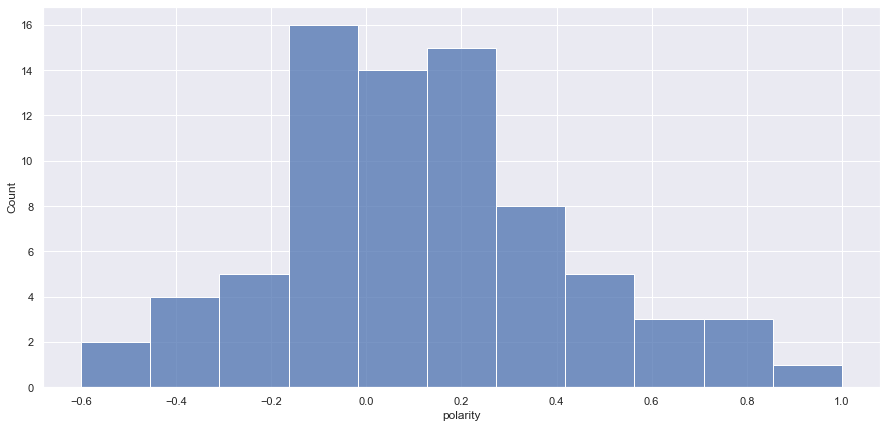

In [215]:
fig = plt.figure(figsize=(15,7))
sns.histplot(Final_df['polarity'])
plt.show()

In [190]:
##### remove neutral values 
Final_df = Final_df[Final_df.polarity != 0]

# Word Cloud

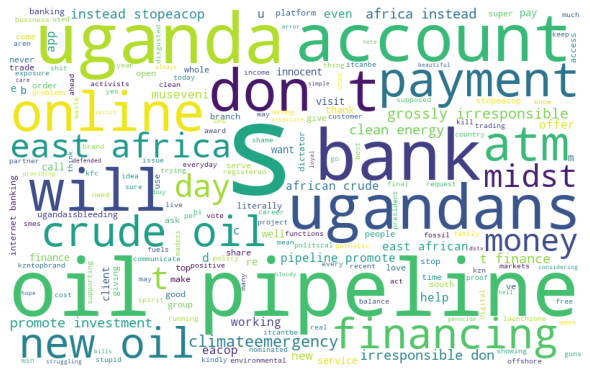

In [188]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

tweetString = " ".join(list(Final_df["cleaned_tweet"]))
tweetString1 = re.sub(r"standard bank","",tweetString)     #remove bank name

wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 5).generate(tweetString1)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

In [153]:
Final_df.head(5)

,date,username,uncleaned_tweet,hashtags,nlikes,search,cleaned_tweet,polarity,subjectivity,Final,mean,rolling
date,,,,,,,,,,,,
2021-06-23 17:08:22,2021-06-23 17:08:22,Bhekala1,Debt Review Restructure Officer - Standard Ban...,"[cv, findwork]",0,Standard Bank,good day kindly note you will need to visit a ...,0.325000,0.500000,Positive,0.325000,NaN
2021-06-23 17:01:12,2021-06-23 17:01:12,newsjourcom,3NEWS: Standard Bank partners with Microsoft ...,"[gh, economy]",0,Standard Bank,yes beautiful i love it,0.675000,0.800000,Positive,0.200000,0.200000
2021-06-23 16:48:00,2021-06-23 16:48:00,MzalendoWatch,A national blood bank is very critical for the...,[bungelivena],1,Standard Bank,i hope this good bank does not associate itsel...,0.600000,0.650000,Positive,0.200000,0.255000
2021-06-23 16:42:10,2021-06-23 16:42:10,etyoung,Just spent 30mins on the phone with @Christies...,[],31,Standard Bank,today the whole day literally the whole bloody...,-0.142500,0.548929,Negative,0.145750,0.091500
2021-06-23 16:28:53,2021-06-23 16:28:53,bimmerbitcorn,@360_trader They solved interoperability thoug...,[],1,Standard Bank,the way i love standard bank and have always b...,-0.002381,0.611905,Negative,0.103937,-0.028976


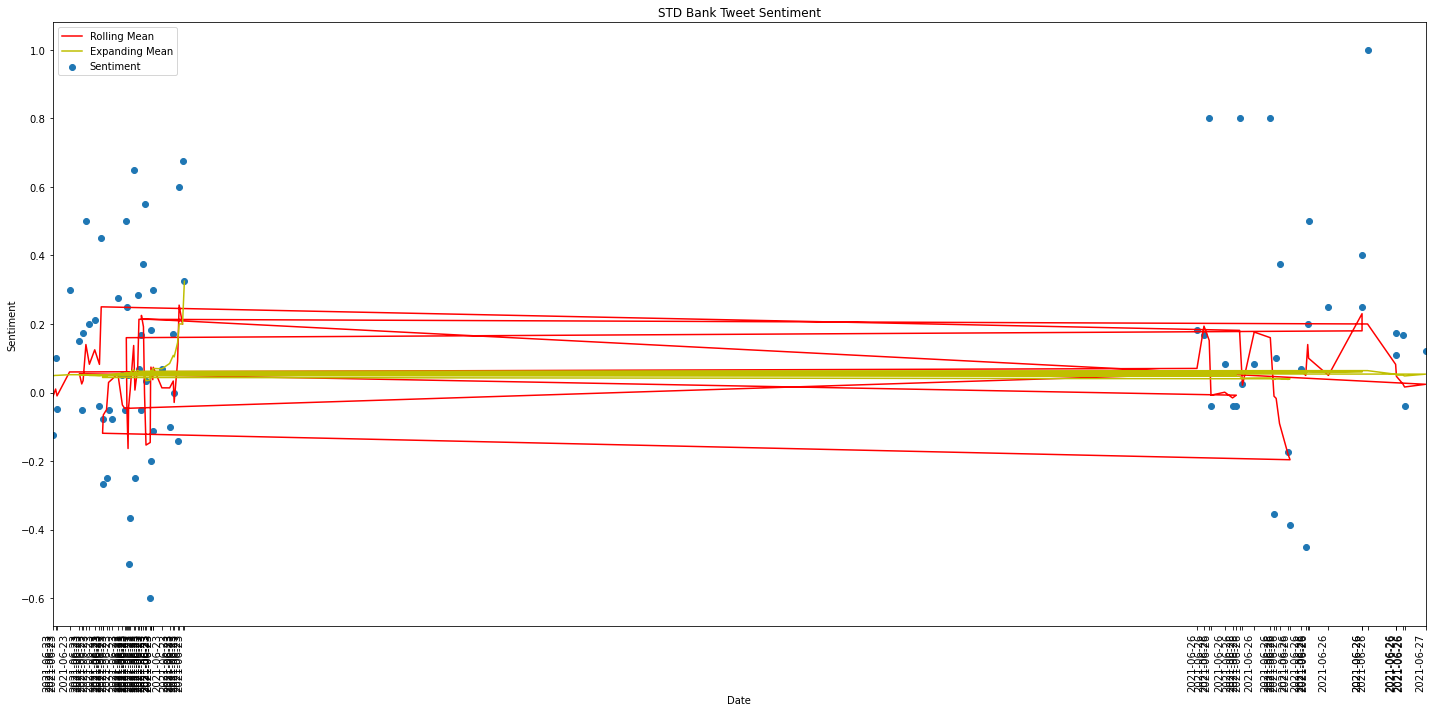

In [154]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

#plot data 
ax.scatter(Final_df['date'],Final_df['polarity'], label='Sentiment')
ax.plot(Final_df['date'],Final_df['rolling'], color ='r', label='Rolling Mean')
ax.plot(Final_df['date'],Final_df['mean'], color='y', label='Expanding Mean')
ax.set(title='STD Bank Tweet Sentiment', xlabel='Date', ylabel='Sentiment')



#x-axis management - how many dates left, right
ax.set_xlim([Final_df['date'][-1], Final_df['date'][0]])

# set monthly locator
#x.xaxis.set_major_locator(mdates.DayLocator(interval=5))
# set formatter
#x.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))


# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.xticks(Final_df['date'], rotation=90)

ax.legend(loc='best')
fig.tight_layout()

plt.show()


In [155]:
Final_df['date'][-1]

Timestamp('2021-06-23 08:38:55')

In [175]:
Final_df.to_csv("NLP_Standardbank_July.csv")